<a href="https://colab.research.google.com/github/yeonui-0626/topic-modeling/blob/main/LDA_gensim_1028.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 필요 패키지 설치 

konlpy : 한글 형태소 분석기

In [ ]:
!pip install konlpy
# !pip install pyLDAvis

### 0. 패키지 로드

gensim :  비지도 주제 모델링 및 자연어 처리를위한 오픈 소스 라이브러리        
Komoran : Java로 쓰여진 오픈소스 한글 형태소 분석기 


In [2]:
# 0. 패키지 로드
import re
import numpy as np
import pandas as pd
from pprint import pprint
import spacy

In [3]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from konlpy.tag import Komoran

### 1. 불용어 준비

직업, 성격을 나타내는 단어 외에 자주 등장하지만    
직업을 구분하거나 성격을 나타지내지 않는 단어들을 불용어로 지정함.

In [5]:
# 1. 불용어 준비
stop_word=['필요','요구','흥미','성격','능력','사람','때문', '관련', '담당','경우',
           '사항','불편','이외','계속','절대','서서']

### 2. 데이터 로드

문서 : 커리어넷에서 직업별 적성 및 흥미 텍스트를 크롤링 한 후,
알바별로 매칭되는 직업의 적성 및 흥미를 저장한 데이터.    
**각 알바별 적성 및 흥미 텍스트가 각 문서가 된다.**


In [ ]:
# 2. 데이터 로드
data_load = pd.read_csv('/content/drive/MyDrive/alba-aptitude.csv', encoding='cp949')
data_load.head()

data=[]

for idx, row in data_load.iterrows():
  if idx == 9 :
     continue
  data.append(row['context'])

data

### 3. 단어 토큰화 - 각 문서마다 단어 토큰화

In [14]:
# 3. 단어 토큰화 - 각 문서마다 단어 토큰화

# 형태소 분석기를 이용한 명사 추출
tagger = Komoran()
def get_nouns(text):
    nouns = tagger.nouns(text)
    return [n for n in nouns if len(n) > 1]

# 각 문서별 추출한 명사 단어들 저장
documents=[]
for i in range(len(data)):
  nouns = get_nouns(data[i])
  doc_word=[]
  for token in nouns:
    if token not in stop_word:
      doc_word.append(token)
  documents.append(doc_word)
len(documents)

149

### 4. 말뭉치 생성(id2word, corpus)

gensim의 LDA 모델을 사용하기 위해서는 **단어사전**과 **말뭉치**가 필요하다.    
단어사전은 id 값을 부여한 문서 전체에서 나타나는 단어들의 모음이다.    
말뭉치는 각 문서별 나타나는 단어돠 단어의 빈도수의 모음이다. 

-----------------------------------------
id2word(단어사전) : 단어에 id값을 부여한 dictionary    
corpus(말뭉치) : id별(단어별) 빈도수

In [15]:
# 4. 말뭉치 생성(id2word, corpus)

id2word = corpora.Dictionary(documents)
corpus = [id2word.doc2bow(document) for document in documents]

print("단어수 : ", len(id2word))
print("id2word : ( 단어, id )")
print(list(id2word.token2id.items())[:5])
print("corpus : ( id, 빈도수 )")
print(corpus[0][:5])

단어수 :  1185
id2word : ( 단어, id )
[('가격', 0), ('개발', 1), ('거스름돈', 2), ('계산', 3), ('고객', 4)]
corpus : ( id, 빈도수 )
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3)]


### 5. LDA 모델 생성

* num_topics : 토픽수
* update_every : 모델 매개변수를 업데이트 해야하는 빈도    
* chunksize : 한번 학습할 때 문서를 얼마나 볼 지    
* passes : 모델 학습시 전체 코퍼스에서 모델을 학습시키는 빈도제어(모델을 학습시키는 횟수, epochs와 동일)    

----------

#### 최적의 토픽수 - num_topics = 30     

모델의 Perplexity(복잡도)가 낮게 나온 토픽의 수를 나눌 토픽의 수로 지정하였다.    
토픽의 수가 증가할 수 록 혼잡도가 계속 낮아졌지만, 분류된 토픽의 단어들이 서로 겹치지 않고 각 토픽 마다 유일한 직업 특성을 보여야하기 때문에 분류된 단어들을 보며 적당한 토픽의 수를 찾음



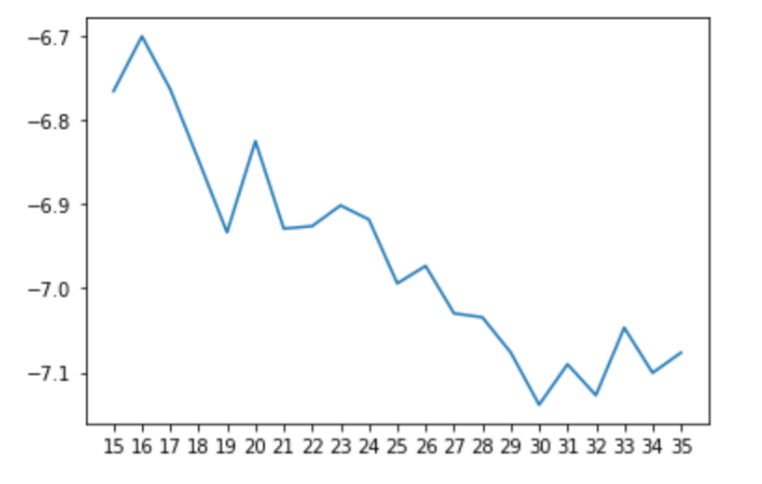



In [16]:
 # 5. 토픽 모델 생성

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                             id2word=id2word,
                                             num_topics=30, 
                                             random_state=100,
                                             update_every=1,
                                             chunksize=100,
                                             passes=10,
                                             alpha='auto',
                                             per_word_topics=True)  

#### 6. 모델 복잡도

#### 복잡도
토픽 모델링도 문서 집합 내 용어 출현 횟수를 바탕으로, 문서 내 주제 출현 확률과 주제 내 용어 출현 활률을 계산하는 확률 모델이므로, 확률 모델을 평가할 때 사용하는 척도를 사용함.


In [18]:
# 복잡도(Perplexity)
perplexity = lda_model.log_perplexity(corpus)

# 일관성(Coherence) - 문서별 대표 단어들이 얼마나 의미적으로 유사한지 판단
# => 모델이 어떻게 한글 단어의 의미를 판단하는 지 몰라 사용 X 
coherence_model_lda  = CoherenceModel(model=lda_model, texts=documents, dictionary=id2word,coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Perplexity : ',perplexity)
print('Coherence Score: ', coherence_lda)

Perplexity :  -6.1910586945524875
Coherence Score:  0.4327066636198079


In [53]:
# 토픽별 단어 출력 30개
topic_words=lda_model.show_topics(num_topics=30,num_words=30, formatted=False)
doc_lda = lda_model[corpus]

print(topic_words[0])

(0, [('체력', 0.032275964), ('기계', 0.031399526), ('작업', 0.030342074), ('기기', 0.028377144), ('습득', 0.026473857), ('위치', 0.024567539), ('장비', 0.020780591), ('협조', 0.02066553), ('기술', 0.020345664), ('사용', 0.019716604), ('사회', 0.01935994), ('장애', 0.018928502), ('진취', 0.018261852), ('인내심', 0.017489078), ('재주', 0.017021544), ('예술', 0.016738744), ('건강', 0.016174737), ('신체', 0.01578996), ('지식', 0.014923382), ('끈기', 0.013772742), ('이해', 0.013563689), ('순발력', 0.013301782), ('계발', 0.013289446), ('도덕', 0.013001539), ('감각', 0.012137941), ('특성', 0.01130983), ('직업', 0.011262889), ('업무', 0.010906457), ('현실', 0.010372372), ('인내', 0.010224405)])


##### 문서별 토픽의 비율 확인

In [31]:
for i, topic_list in enumerate(lda_model[corpus]):
  if i==5:
    break;
  print(i,'번째 문서의 topic 비율은',topic_list[0])

0 번째 문서의 topic 비율은 [(1, 0.33486113), (3, 0.6501015)]
1 번째 문서의 topic 비율은 [(3, 0.12821504), (15, 0.6403752), (17, 0.22399268)]
2 번째 문서의 topic 비율은 [(15, 0.74174815), (17, 0.24903178)]
3 번째 문서의 topic 비율은 [(17, 0.9857578)]
4 번째 문서의 topic 비율은 [(17, 0.9857578)]


##### 문서별 가장 비중이 큰 토픽 확인

In [32]:
def make_topictable_per_doc(lda_model, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(lda_model[corpus]):
        doc = topic_list[0] if lda_model.per_word_topics else topic_list[0]            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list[0]]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [ ]:
topictable = make_topictable_per_doc(lda_model, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']

In [35]:
job_list=[]
for idx, row in data_load.iterrows():
    if idx == 9: continue
    job_list.append(row['alba_name'])

topictable.index = job_list

In [54]:
topictable[:10]

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
일반음식점,0,3.0,0.6501,"[(1, 0.33486563), (3, 0.650097)]"
레스토랑,1,15.0,0.6404,"[(3, 0.12825072), (15, 0.64037305), (17, 0.223..."
패밀리레스토랑,2,15.0,0.7418,"[(15, 0.7417609), (17, 0.24901895)]"
패스트푸드점,3,17.0,0.9858,"[(17, 0.9857578)]"
치킨ㆍ피자전문점,4,17.0,0.9858,"[(17, 0.9857578)]"
커피전문점,5,17.0,0.9866,"[(17, 0.986584)]"
아이스크림ㆍ디저트,6,17.0,0.9866,"[(17, 0.986584)]"
베이커리ㆍ도넛ㆍ떡,7,1.0,0.3985,"[(1, 0.3985121), (14, 0.103884965), (16, 0.158..."
호프ㆍ일반주점,8,15.0,0.4986,"[(15, 0.4985675), (17, 0.49025208)]"
급식ㆍ푸드시스템,9,3.0,0.6002,"[(3, 0.60023844), (15, 0.34542674), (16, 0.041..."


##### 토픽별 단어 저장

In [50]:
# 토픽별 단어 저장
words_df = pd.DataFrame(index=range(0,30), columns=['words'])

for i in range(len(topic_words)):
  words_list = topic_words[i][1]
  tmp =[]
  for k in range(len(words_list)):
    tmp.append(words_list[k][0])
  words_df.loc[i,'words'] = tmp

In [52]:
words_df.to_csv("gensim-토픽별단어.csv")